# Feature Detection

This Notebook is used to test the detection ability of the NeuroKit2 library to detect features in the ECG dataset. Those features than are important to train the model to detect the different diagnostic groups. The features are generated using the NeuroKit2 library.

In [2]:
from matplotlib import pyplot as plt
import wfdb.processing
import sys
import json
import scipy
import numpy as np
import neurokit2 as nk
import math

sys.path.append('../scripts')
import data_helper

# possible liberays to use:
# https://neuropsychology.github.io/NeuroKit/examples/ecg_delineate/ecg_delineate.html
# https://biosppy.readthedocs.io/en/stable/
# https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/
# https://pywavelets.readthedocs.io/en/latest/

## Load Data

In [3]:
data_org = data_helper.load_data(only_demographic=False)

print("Number of patients per category:")
for cat_name in data_org.keys():
    print(f"{cat_name}: {len(data_org[cat_name])}")

Reading GSVT
Reading AFIB
Reading SR
Reading SB
Number of patients per category:
GSVT: 1027
AFIB: 9787
SR: 10426
SB: 15826


# Noise Reduction
Load the parameters needed to filter the data

In [4]:
with open('../filter_params.json', 'r') as f:
    filter_params = json.load(f)

In [5]:
example_data = data_org['SB'][0]
sig_channel= 0

In [6]:
filtered_data = data_helper.filter_data(example_data, filter_params)

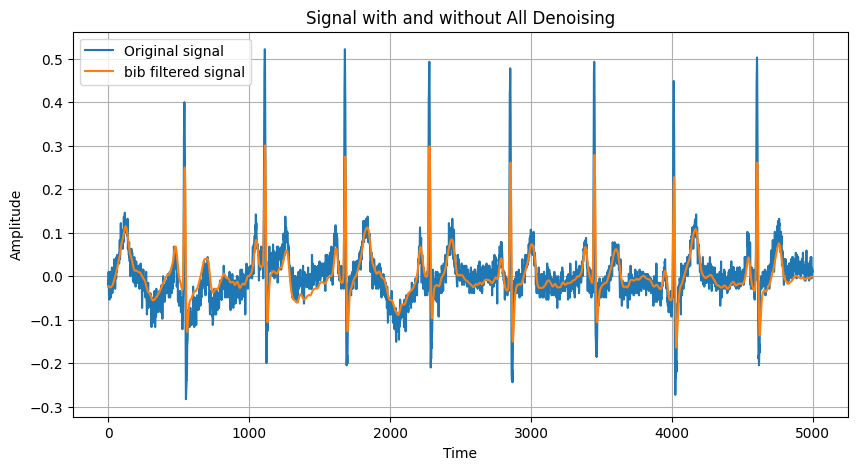

In [7]:
#data = filtered_data.p_signal[:,sig_channel]
ecg_signal = data_org['SB'][0].p_signal[:,sig_channel]
ecg_signal = filtered_data.p_signal[:,sig_channel]

sampling_rate = 500 # Sampling rate of your ECG data


ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)

# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(example_data.p_signal[:,0], label='Original signal')
plt.plot(ecg_cleaned, label='bib filtered signal')
#plt.plot(filtered_data.p_signal[:,0], label='self filtered signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without All Denoising')
plt.legend()
plt.grid(True)
plt.show()


# Detect Peaks

In [8]:
# Extract R-peaks
_, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)

# Extract all ECG features
ecg_signals, info = nk.ecg_delineate(ecg_cleaned, rpeaks, sampling_rate=sampling_rate, method="dwt")

# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
p_peaks = info['ECG_P_Peaks']
p_onsets = info['ECG_P_Onsets']
p_offsets = info['ECG_P_Offsets']
print(p_peaks)
print(p_onsets)
print(p_offsets)

p_peaks_y = [ecg_cleaned[i] for i in p_peaks] 
p_onsets_y = [ecg_cleaned[i] for i in p_onsets]
p_offsets_y = [ecg_cleaned[i] for i in p_offsets]

[477, 1050, 1617, 2216, 2750, 3386, 3890, 4482]
[439, 1019, 1590, 2186, 2727, 3356, 3876, 4458]
[512, 1075, 1647, 2248, 2757, 3421, 3915, 4496]


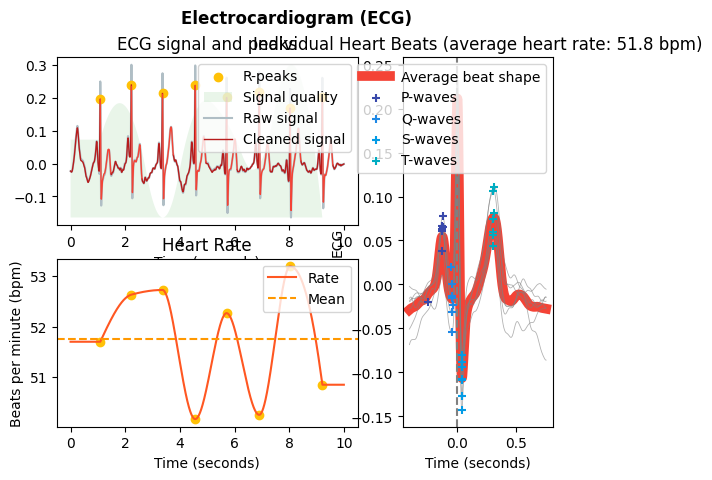

In [9]:
# Process it
signals, info = nk.ecg_process(ecg_cleaned, sampling_rate=500)

# Visualise the processing
nk.ecg_plot(signals, info)

[693, 1262, 1835, 2435, 3005, 3603, 4165, 4758]
[636, 1234, 1786, 2388, 2947, 3546, 4122, 4698]
[737, 1307, 1881, 2476, 3049, 3651, 4214, 4799]


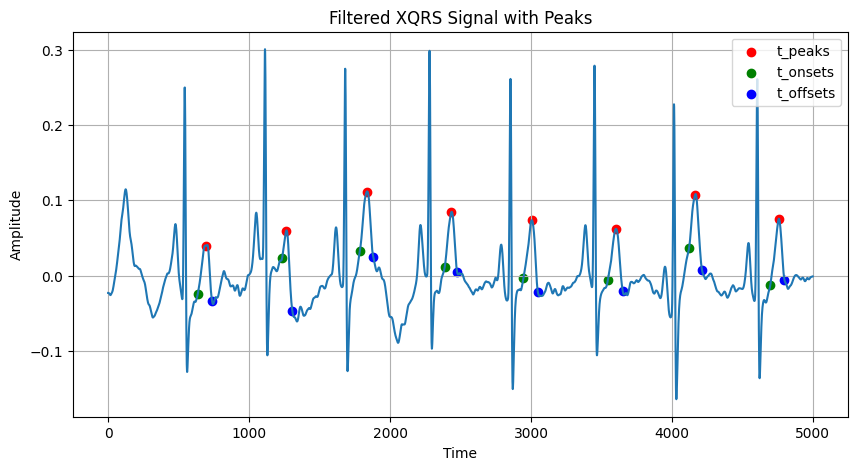

In [10]:
t_peaks = info['ECG_T_Peaks']
t_onsets = info['ECG_T_Onsets']
t_offsets = info['ECG_T_Offsets']

print(t_peaks)
print(t_onsets)
print(t_offsets)

t_peaks_y = [ecg_cleaned[i] for i in t_peaks] 
t_onsets_y = [ecg_cleaned[i] for i in t_onsets]
t_offsets_y = [ecg_cleaned[i] for i in t_offsets]

plt.figure(figsize=(10, 5))
plt.plot(ecg_cleaned)
plt.scatter(t_peaks, t_peaks_y, color='red', label='t_peaks')
plt.scatter(t_onsets, t_onsets_y, color='green', label='t_onsets')
plt.scatter(t_offsets, t_offsets_y, color='blue', label='t_offsets')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered XQRS Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

[477, 1050, 1617, 2217, 2788, 3386, 3890, 4543]
[438, 1018, 1589, 2184, 2763, 3355, 3876, 4511]
[514, 1076, 1648, 2248, 2820, 3421, 3914, 4574]


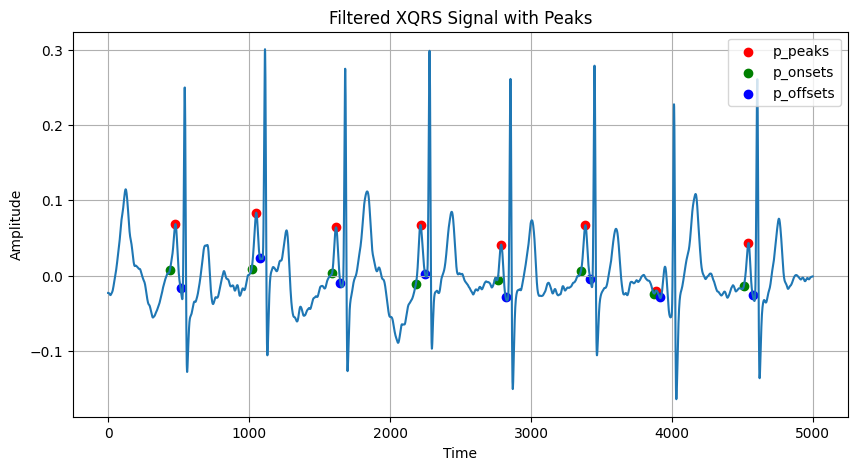

In [11]:
p_peaks = info['ECG_P_Peaks']
p_onsets = info['ECG_P_Onsets']
p_offsets = info['ECG_P_Offsets']
print(p_peaks)
print(p_onsets)
print(p_offsets)

p_peaks_y = [ecg_cleaned[i] for i in p_peaks] 
p_onsets_y = [ecg_cleaned[i] for i in p_onsets]
p_offsets_y = [ecg_cleaned[i] for i in p_offsets]

plt.figure(figsize=(10, 5))
plt.plot(ecg_cleaned)
plt.scatter(p_peaks, p_peaks_y, color='red', label='p_peaks')
plt.scatter(p_onsets, p_onsets_y, color='green', label='p_onsets')
plt.scatter(p_offsets, p_offsets_y, color='blue', label='p_offsets')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered XQRS Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()


[523, 1086, 1658, 2256, 2830, 3430, 3990]
[563, 1132, 1701, 2300, 2873, 3471, 4034]
[482, 1055, 1622, 2221, 2794, 3391, 3957]
[580, 1151, 1720, 2317, 2893, 3491, 4055]


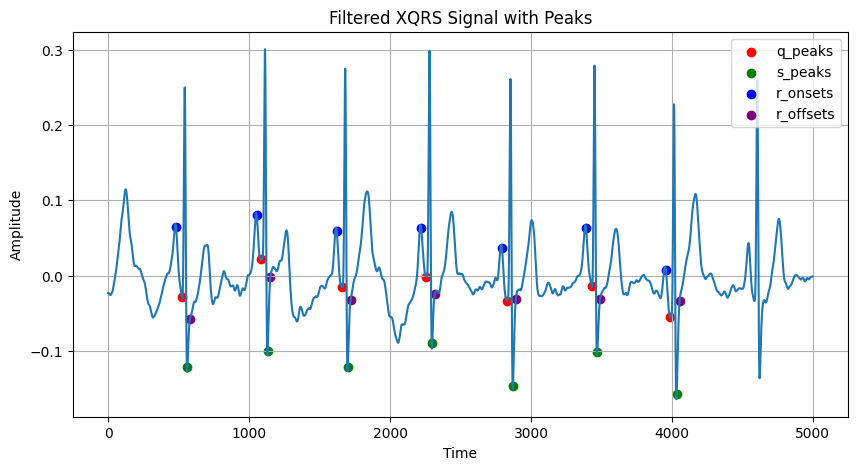

In [12]:
# 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks'


q_peaks = info['ECG_Q_Peaks'][:-1]
s_peaks = info['ECG_S_Peaks'][:-1]
r_onsets = info['ECG_R_Onsets'][:-1]
r_offsets = info['ECG_R_Offsets'][:-1]

print(q_peaks)
print(s_peaks)
print(r_onsets)
print(r_offsets)

q_peaks_y = [ecg_cleaned[i] for i in q_peaks] 
s_peaks_y = [ecg_cleaned[i] for i in s_peaks]
r_onsets_y = [ecg_cleaned[i] for i in r_onsets]
r_offsets_y = [ecg_cleaned[i] for i in r_offsets]

plt.figure(figsize=(10, 5))
plt.plot(ecg_cleaned)
plt.scatter(q_peaks, q_peaks_y, color='red', label='q_peaks')
plt.scatter(s_peaks, s_peaks_y, color='green', label='s_peaks')
plt.scatter(r_onsets, r_onsets_y, color='blue', label='r_onsets')
plt.scatter(r_offsets, r_offsets_y, color='purple', label='r_offsets')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered XQRS Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

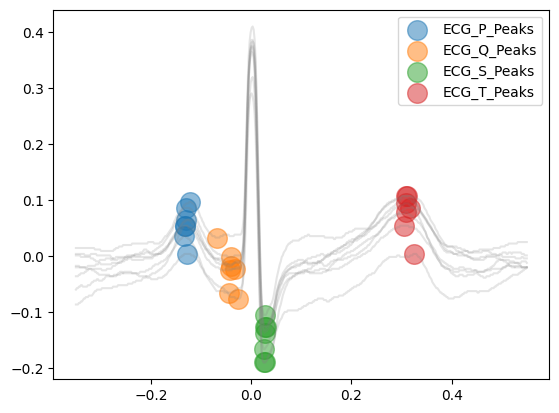

In [13]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(ecg_signal, 
                                 rpeaks, 
                                 sampling_rate=500, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

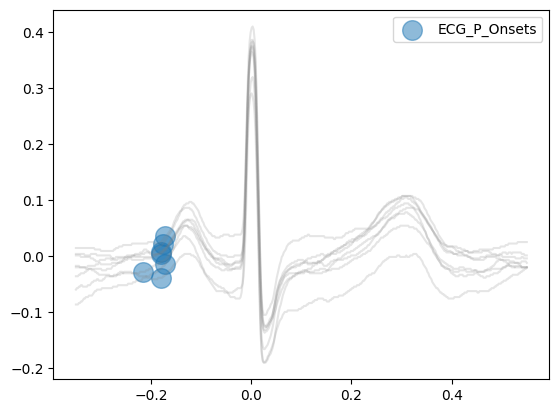

In [14]:
# Delineate the ECG signal and visualizing all P-peaks boundaries
signal_peak, waves_peak = nk.ecg_delineate(ecg_signal, 
                                           rpeaks, 
                                           sampling_rate=500,
                                           method="peak", 
                                           show=True, 
                                           show_type='bounds_P')

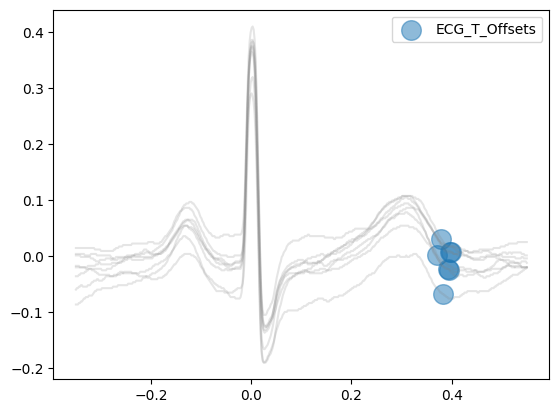

In [15]:
# Delineate the ECG signal and visualizing all T-peaks boundaries
signal_peaj, waves_peak = nk.ecg_delineate(ecg_signal, 
                                           rpeaks, 
                                           sampling_rate=500, 
                                           method="peak", 
                                           show=True, 
                                           show_type='bounds_T')

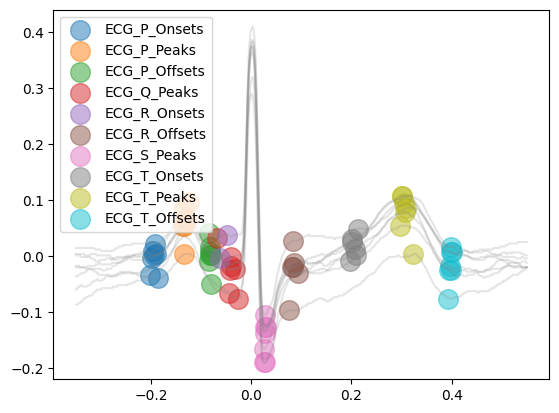

In [16]:
# Delineate the ECG signal
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='all')

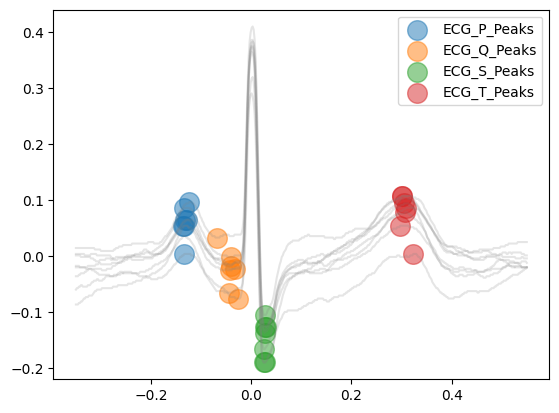

In [17]:
# Visualize P-peaks and T-peaks
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='peaks')

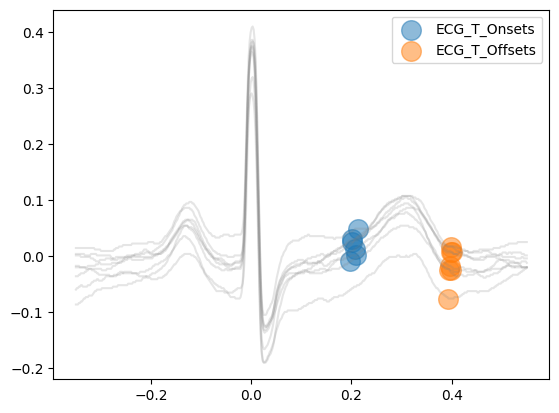

In [18]:
# Visualize T-waves boundaries
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_T')

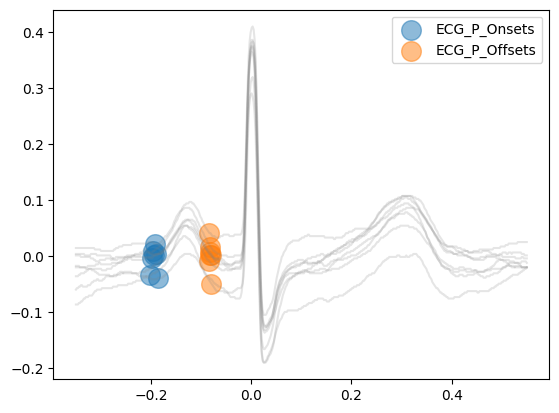

In [19]:
# Visualize P-waves boundaries
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_P')

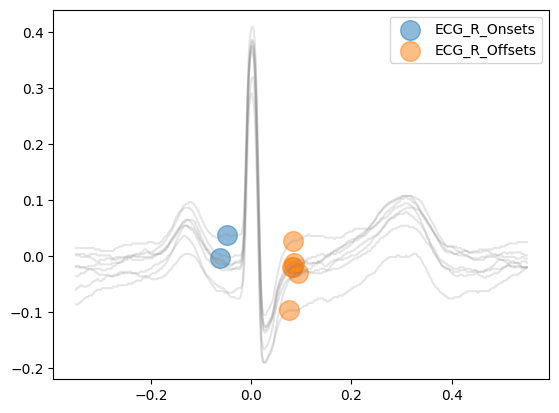

In [20]:
# Visualize R-waves boundaries
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_R')

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 544 1114 1683 2281 2855 3452 4016 4606]


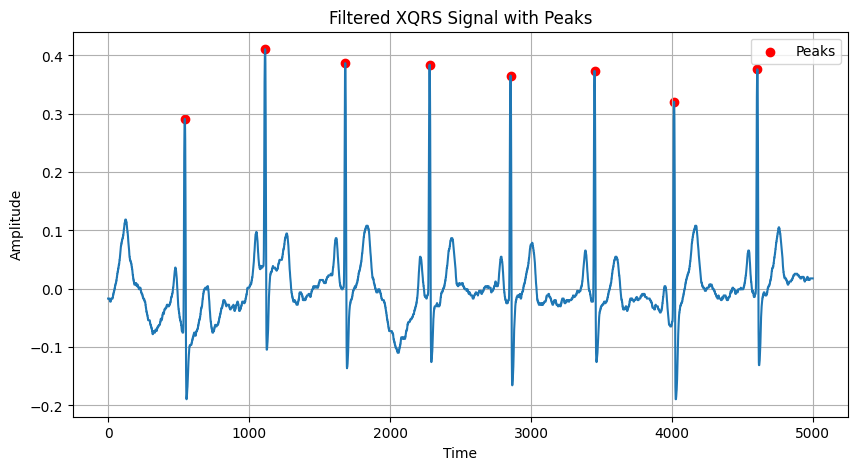

In [21]:
# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
indicies = wfdb.processing.xqrs_detect(filtered_data.p_signal[:,sig_channel],example_data.fs,0,5000)
print(indicies)

peak_points_y = [filtered_data.p_signal[:,sig_channel][i] for i in indicies] 

plt.figure(figsize=(10, 5))
plt.plot(filtered_data.p_signal[:,sig_channel])
plt.scatter(indicies, peak_points_y, color='red', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered XQRS Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

## Calculate R and T Axis for one datapoint

In [22]:
def calculate_axis(data, leads, sampling_rate=500, aVF=5, I=0):
    # warnining if leads not include 0 and 5 or one lead is over 5
    if not (I in leads and aVF in leads) or any([lead > aVF for lead in leads]) or len(leads) > 6:
        print("Warning: Leads should include 0 and 5, and should not include a lead over 5")
        return None, None
    # Calculate the net QRS in each lead
    net_qrs = {}
    net_t = {}
    for lead in leads:
        # get data and peaks
        ecg_signal = data.p_signal[:,lead]
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=500)
        # r axis
        # get amplitude of peaks
        q_peaks = [ecg_signal[int(i)] for i in info['ECG_Q_Peaks'] if not math.isnan(i)]
        s_peaks = [ecg_signal[int(i)] for i in info['ECG_S_Peaks'] if not math.isnan(i)]
        _, rpeaks_idx = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)
        rpeaks_idx = rpeaks_idx['ECG_R_Peaks']
        r_peaks = [ecg_signal[int(i)] for i in rpeaks_idx if not math.isnan(i)]
        # calculate avg peal amplitude
        q_peaks_avg = np.mean(q_peaks) if q_peaks else 0
        s_peaks_avg = np.mean(s_peaks) if s_peaks else 0
        r_peaks_avg = np.mean(r_peaks) if r_peaks else 0
        # Calculate net QRS in lead
        net_qrs[lead] = r_peaks_avg - (q_peaks_avg + s_peaks_avg)

        # T axis
        t_peaks = [ecg_signal[int(i)] for i in info['ECG_T_Peaks'] if not math.isnan(i)]
        net_t[lead] = np.mean(t_peaks) if t_peaks else 0

    print(net_qrs.get(aVF, 0), net_qrs.get(I, 0))
    # Calculate the R axis (Convert to degrees)
    r_axis = np.arctan2(net_qrs.get(aVF, 0), net_qrs.get(I, 0)) * (180 / np.pi)

    # Calculate the T axis (Convert to degrees)
    t_axis = np.arctan2(net_t.get(aVF, 0), net_t.get(I, 0)) * (180 / np.pi)
    
    return r_axis, t_axis





In [23]:
# print(data_org['SB'][0].__dict__) 'sig_name': ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

i_sig = 0
avf = 5
sampling_rate = 500

example_data = data_org['SB'][0]
filtered_data = data_helper.filter_data(example_data, filter_params)


r_ax, t_ax = calculate_axis(filtered_data, [0, 5], sampling_rate=500)
print(f"2 lead R Axis: {r_ax:.2f} degrees")
print(f"2 lead T Axis: {t_ax:.2f} degrees")
print("")


0.8047692058411333 0.5260930603345693
2 lead R Axis: 56.83 degrees
2 lead T Axis: 30.78 degrees

